# Brief analysis of electricity consumption due to Bitcoin mining

In this notebook I calculate an approximation share of usage of total world electricity generation by Bitcoin mining. I make some plots along the way to make the numbers more digestible.
To this end, I use the following data sets:
1. BP's Statistical Review 2021: https://www.bp.com/en/global/corporate/energy-economics/statistical-review-of-world-energy.html
2. Bitcoin Energy Consumption Index by Digiconomist: https://digiconomist.net/bitcoin-energy-consumption/
3. Time series of daily close prices of Bitcoin in USD as given at stooq.com under the ticker 'BTCUSD': https://stooq.com/q/?s=btcusd


This analysis is by no means exhaustive as it is meant to be a quick and dirty attempt at quantyfing the order of magnitude of the phenomenon at hand.

In [2]:
library(data.table)
library(tidyverse)
library(magrittr)
library(lubridate)
library(scales)
library(hrbrthemes)
library(TTR)
library(zoo)

In [13]:
# 1. load the data on annualized bitcoin electricity consumption
dtBitcoin <- data.table::fread(
  input = "data/bitcoin_electricity_consumption_index_by_digiconomist.csv",
  colClasses = c("Date", "double", "double"))
data.table::setnames(x = dtBitcoin, old = "Estimated TWh per Year", 
                     new = "estimated_annualized_bitcoin_pwr_cons_twh")
dtBitcoin <- dtBitcoin[, list(Date, estimated_annualized_bitcoin_pwr_cons_twh)]
dtBitcoin[, date_year := lubridate::year(x = Date)]
# 2. load the data on world electricity generation based on BP 
dtWorldElectGen <- data.table::fread(
  file = "data/bp_electricity_generation_world_terawatthours.csv",
  colClasses = c("integer", "double"))
# 3. join the data
dtBitcoinShare <- data.table::merge.data.table(
  x = dtBitcoin, y = dtWorldElectGen,
  by.x = "date_year", by.y = "data_year",
  all.x = T, all.y = F)
# use yearly 2020 power generation for Y2021 dates
dtBitcoinShare[, electricity_generation_total_world_terawatthours := 
                 zoo::na.locf0(electricity_generation_total_world_terawatthours, fromLast = F)]
dtBitcoinShare <- dtBitcoinShare[, date_year := NULL]
dtBitcoinShare[, bitcoin_share := estimated_annualized_bitcoin_pwr_cons_twh / 
                 electricity_generation_total_world_terawatthours]

In [14]:
options(repr.plot.width=15, repr.plot.height=10)

In [21]:
# 4. plot the bitcoin share of electricity usage
plotBitcoinElectricityUsage <- ggplot(data = dtBitcoinShare, mapping = aes(x = Date, y = bitcoin_share)) +
  geom_line() + 
  theme_bw() +
  scale_y_continuous(labels = scales::percent) +
  xlab("Date") +
  ylab("Percent") +
  scale_x_date(date_labels = "%m/%Y", date_breaks = "6 month") +
  ggtitle(
    label = "Approx. Bitcoin mining's usage of World's electricity generation", 
    subtitle = "Time series is calculated as ratio of Digiconomist's BECI index to yearly electricity generation in BP's Statistical Review 2021"
  ) +
  theme(plot.title = element_text(size = 22), plot.subtitle = element_text(size = 16))

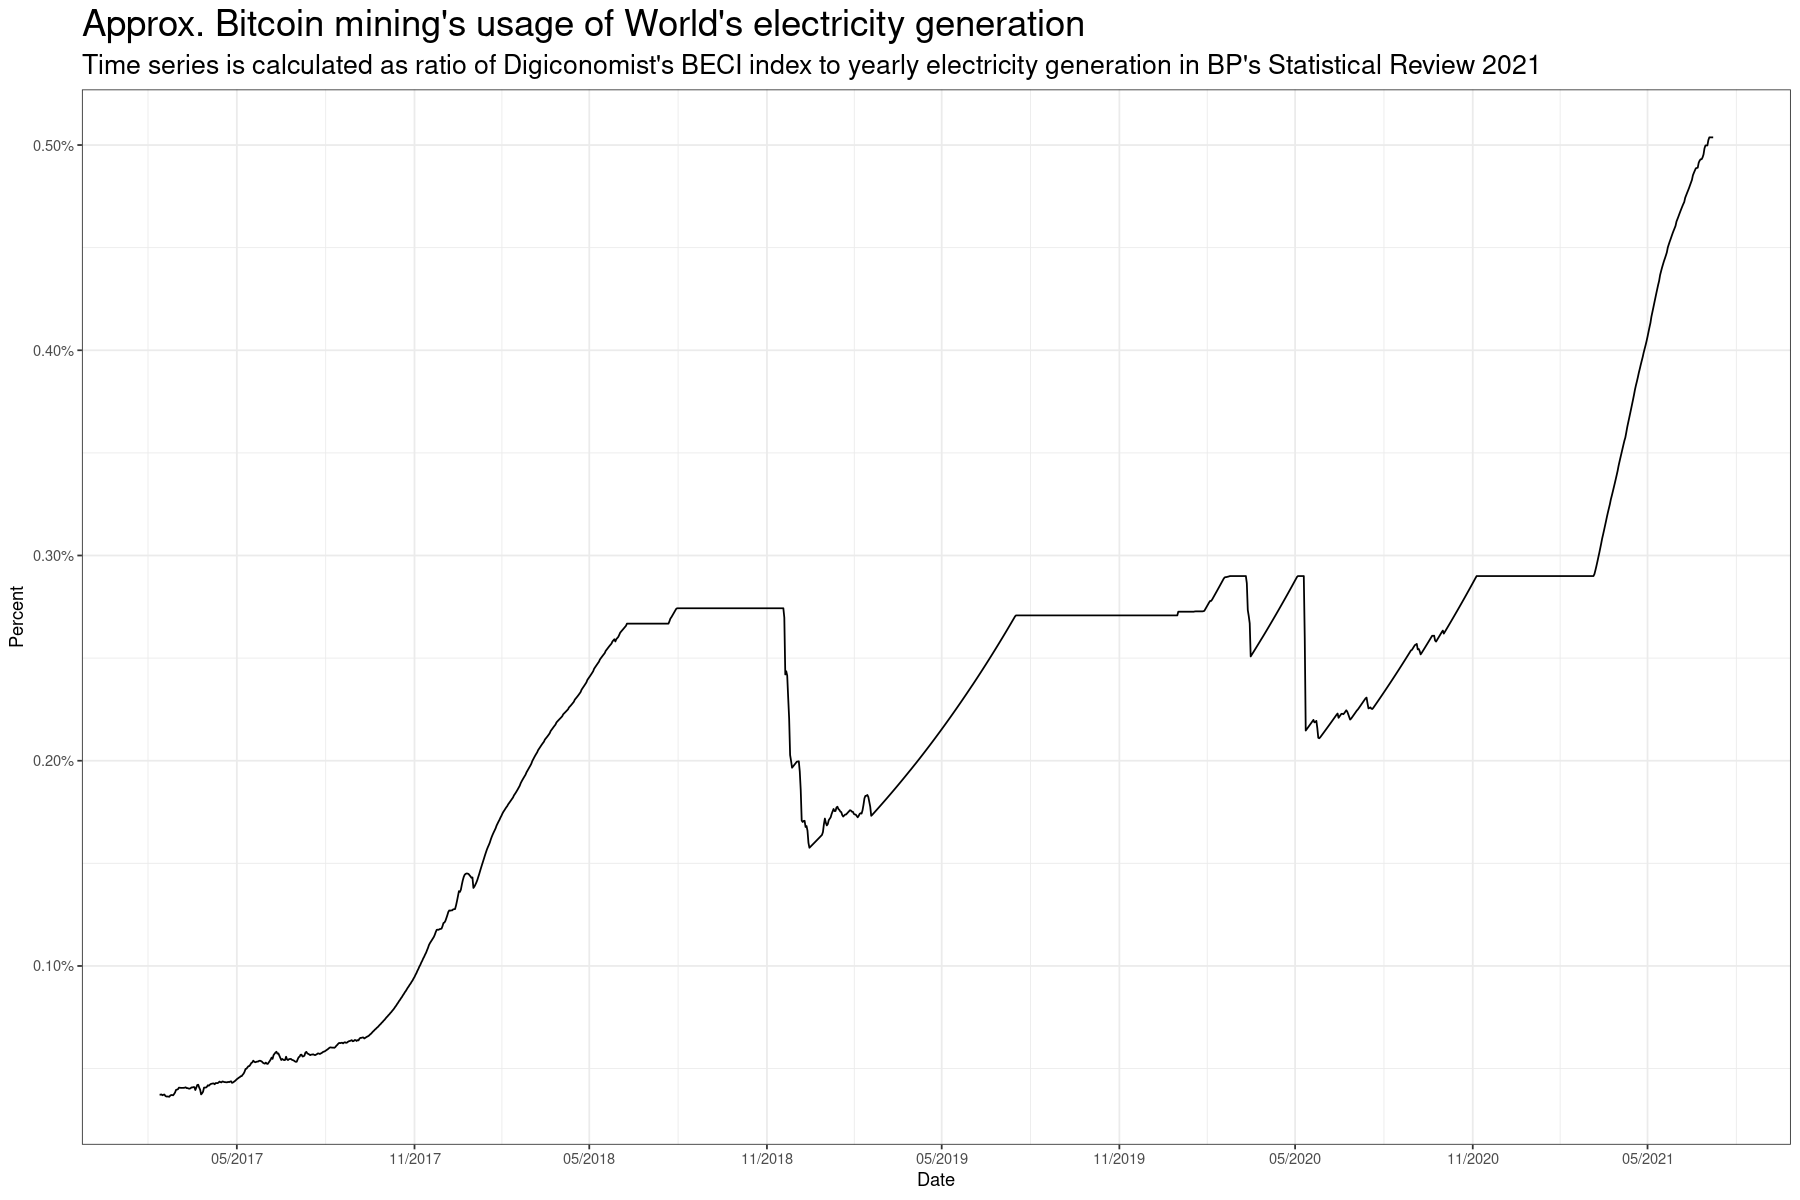

In [22]:
plotBitcoinElectricityUsage

In [17]:
# 5. world electricity generation - a tiny bit more of analysis
dtWorldElectGen[
  , electricity_generation_total_world_terawatthours_ma7y := 
    TTR::SMA(
      x = dtWorldElectGen$electricity_generation_total_world_terawatthours, n = 7)]
data.table::setnames(
  x = dtWorldElectGen,
  old = c("electricity_generation_total_world_terawatthours", "electricity_generation_total_world_terawatthours_ma7y"),
  new = c("generation", "generation_7y_ma"))
dtMeltedWorldElectGen <- data.table::melt.data.table(
    data = dtWorldElectGen, id.vars = "data_year",
    measure.vars = c("generation", "generation_7y_ma"), variable.name = "which_variable", 
    value.name = "variable_value")
# 5.2. plot
plotWorldElectGen <- ggplot(data = dtMeltedWorldElectGen, 
       mapping = aes(x = data_year, y = variable_value, color = which_variable)) +
  geom_line() + geom_point() +
  theme_ipsum() + 
  ggtitle(
    label = "World's yearly electricity generation in TWH",
    subtitle = "Based on BP's Statistical Review 2021 [spreadsheet data sheet 'Electricity Generation']"
  ) +
  xlab("Year") + 
  ylab("Electricity generation in TWh") +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20),
    plot.subtitle = element_text(hjust = 0.5, size = 15),
    axis.title.x = element_text(hjust = 0.5, size = 15),
    axis.title.y = element_text(hjust = 0.5, size = 15),
    legend.position = "bottom"
  ) + 
  scale_y_continuous(labels = scales::comma) + 
  scale_x_continuous(
    breaks = seq(1990, 2021, 5)
  ) + scale_color_discrete(
    name = "Legend: ",
    labels = c("yearly generation", "7-year average of yearly generation")
  )

Warning message:
“Removed 6 row(s) containing missing values (geom_path).”
Warning message:
“Removed 6 rows containing missing values (geom_point).”


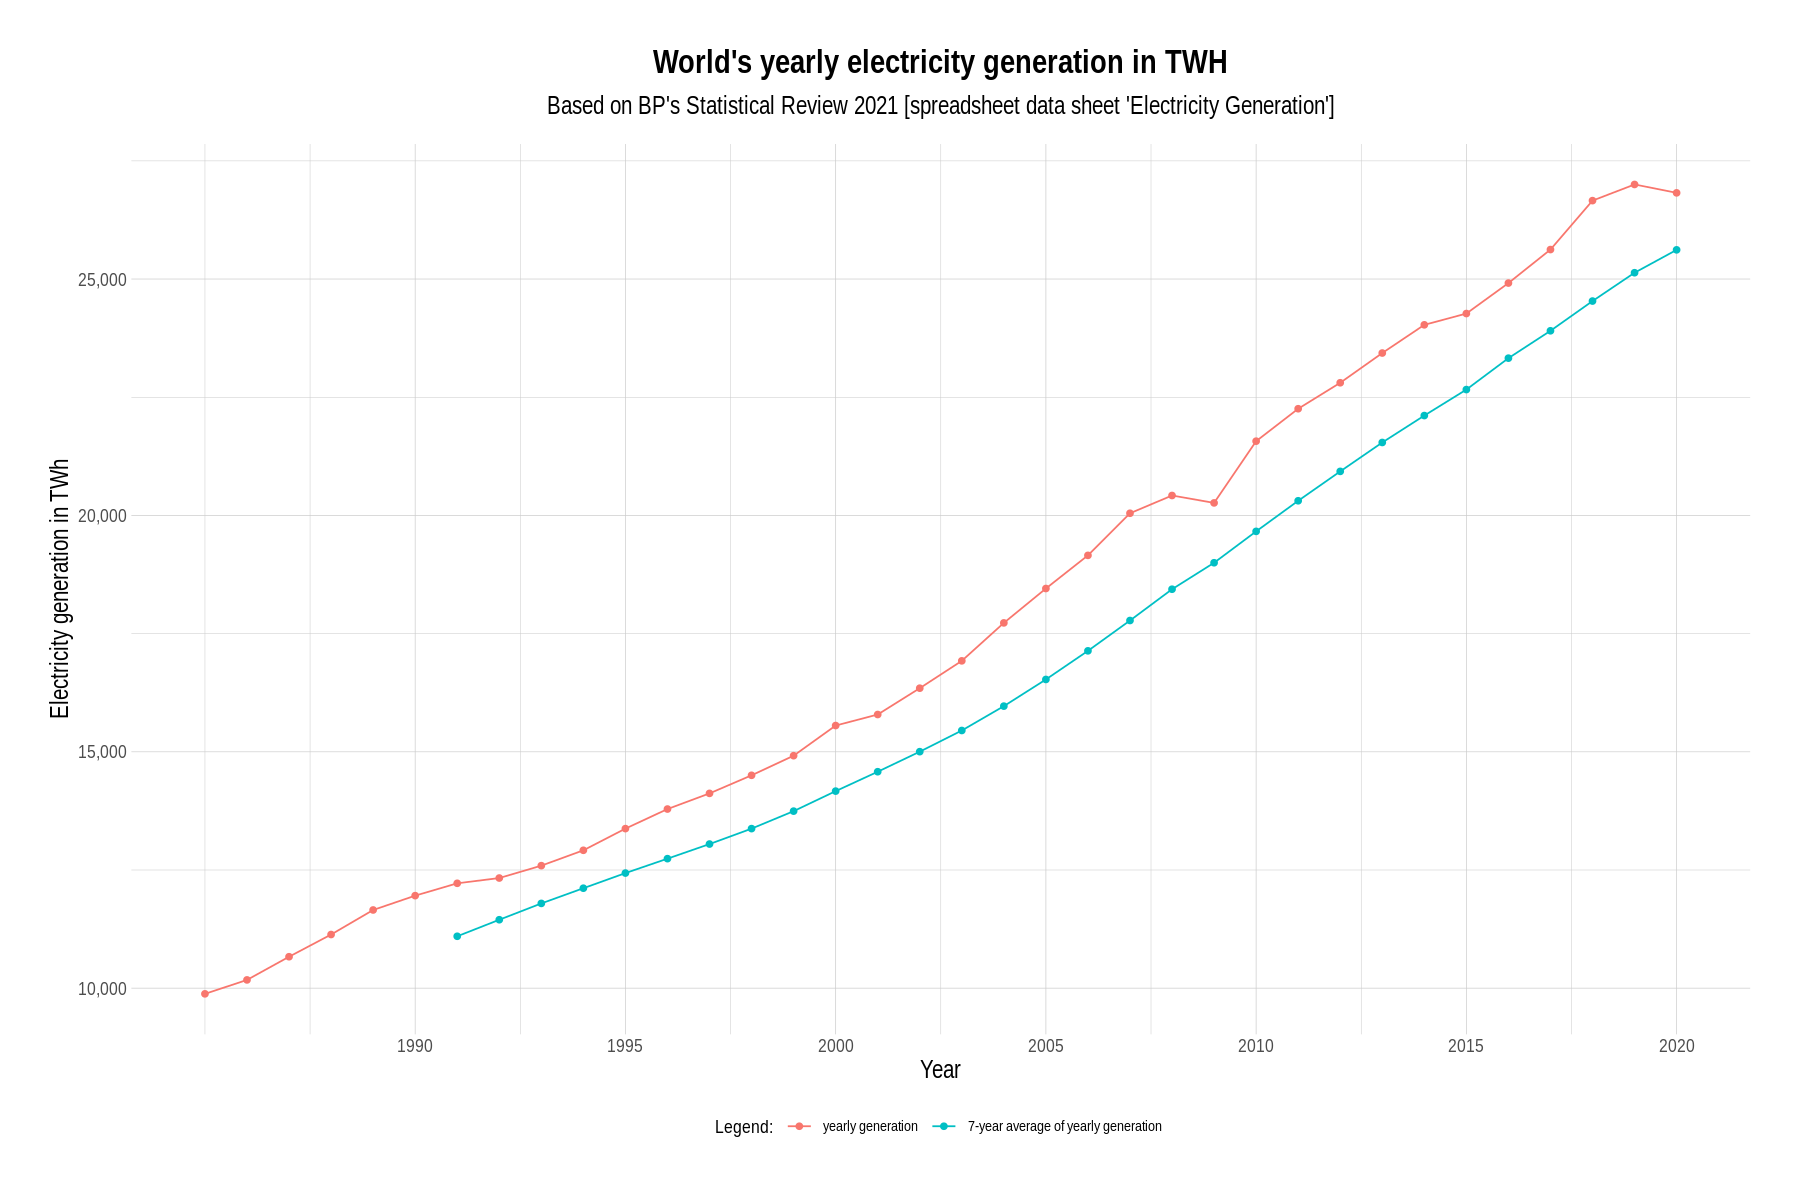

In [18]:
plotWorldElectGen

In [28]:
# 6. include Bitcoin price data in the analysis
# 6.1. load the prices and get a glance of their evolution since 2015
dtBitcoinPrices <- data.table::fread(file = "data/btcusd_d.csv", select = c("Date", "Close"))
dtBitcoinPrices <- dtBitcoinPrices[lubridate::year(Date) >= 2015, ]
colnames(dtBitcoinPrices) <- c("quote_date", "bitcoin_price_USD")
View(head(dtBitcoinPrices))

quote_date,bitcoin_price_USD
<date>,<dbl>
2015-01-02,315.03
2015-01-05,270.93
2015-01-06,283.77
2015-01-07,294.92
2015-01-08,283.53
2015-01-09,290.18


In [31]:
dtBitcoinPrices <- dtBitcoinPrices[
  , `:=`(
    logret_bitcoin_price = c(NA, diff(log(dtBitcoinPrices$bitcoin_price_USD))),
    sq_logret_bitcoin_price = c(NA, diff(log(dtBitcoinPrices$bitcoin_price_USD)))^2)]
View(head(dtBitcoinPrices))

quote_date,bitcoin_price_USD,logret_bitcoin_price,sq_logret_bitcoin_price
<date>,<dbl>,<dbl>,<dbl>
2015-01-02,315.03,NA,NA
2015-01-05,270.93,-0.15080739,0.0227428681
2015-01-06,283.77,0.04630357,0.0021440202
2015-01-07,294.92,0.03854008,0.0014853379
2015-01-08,283.53,-0.03938620,0.0015512724
2015-01-09,290.18,0.02318348,0.0005374739


In [32]:
plotDailyLogReturns <- ggplot(data = dtBitcoinPrices, mapping = aes(x = quote_date, y = logret_bitcoin_price)) +
  geom_line() + theme_bw() + 
  xlab("Quote date") + 
  ylab("Daily log-return") +
  scale_x_date(
    date_labels = "M%mY%Y",
    date_breaks = "12 months"
  ) + 
  ggtitle(
    label = "Daily log-returns of Bitcoin close price, 2015-2021",
    subtitle = "Based on Stooq.com data"
  ) + scale_y_continuous(labels = scales::percent)

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


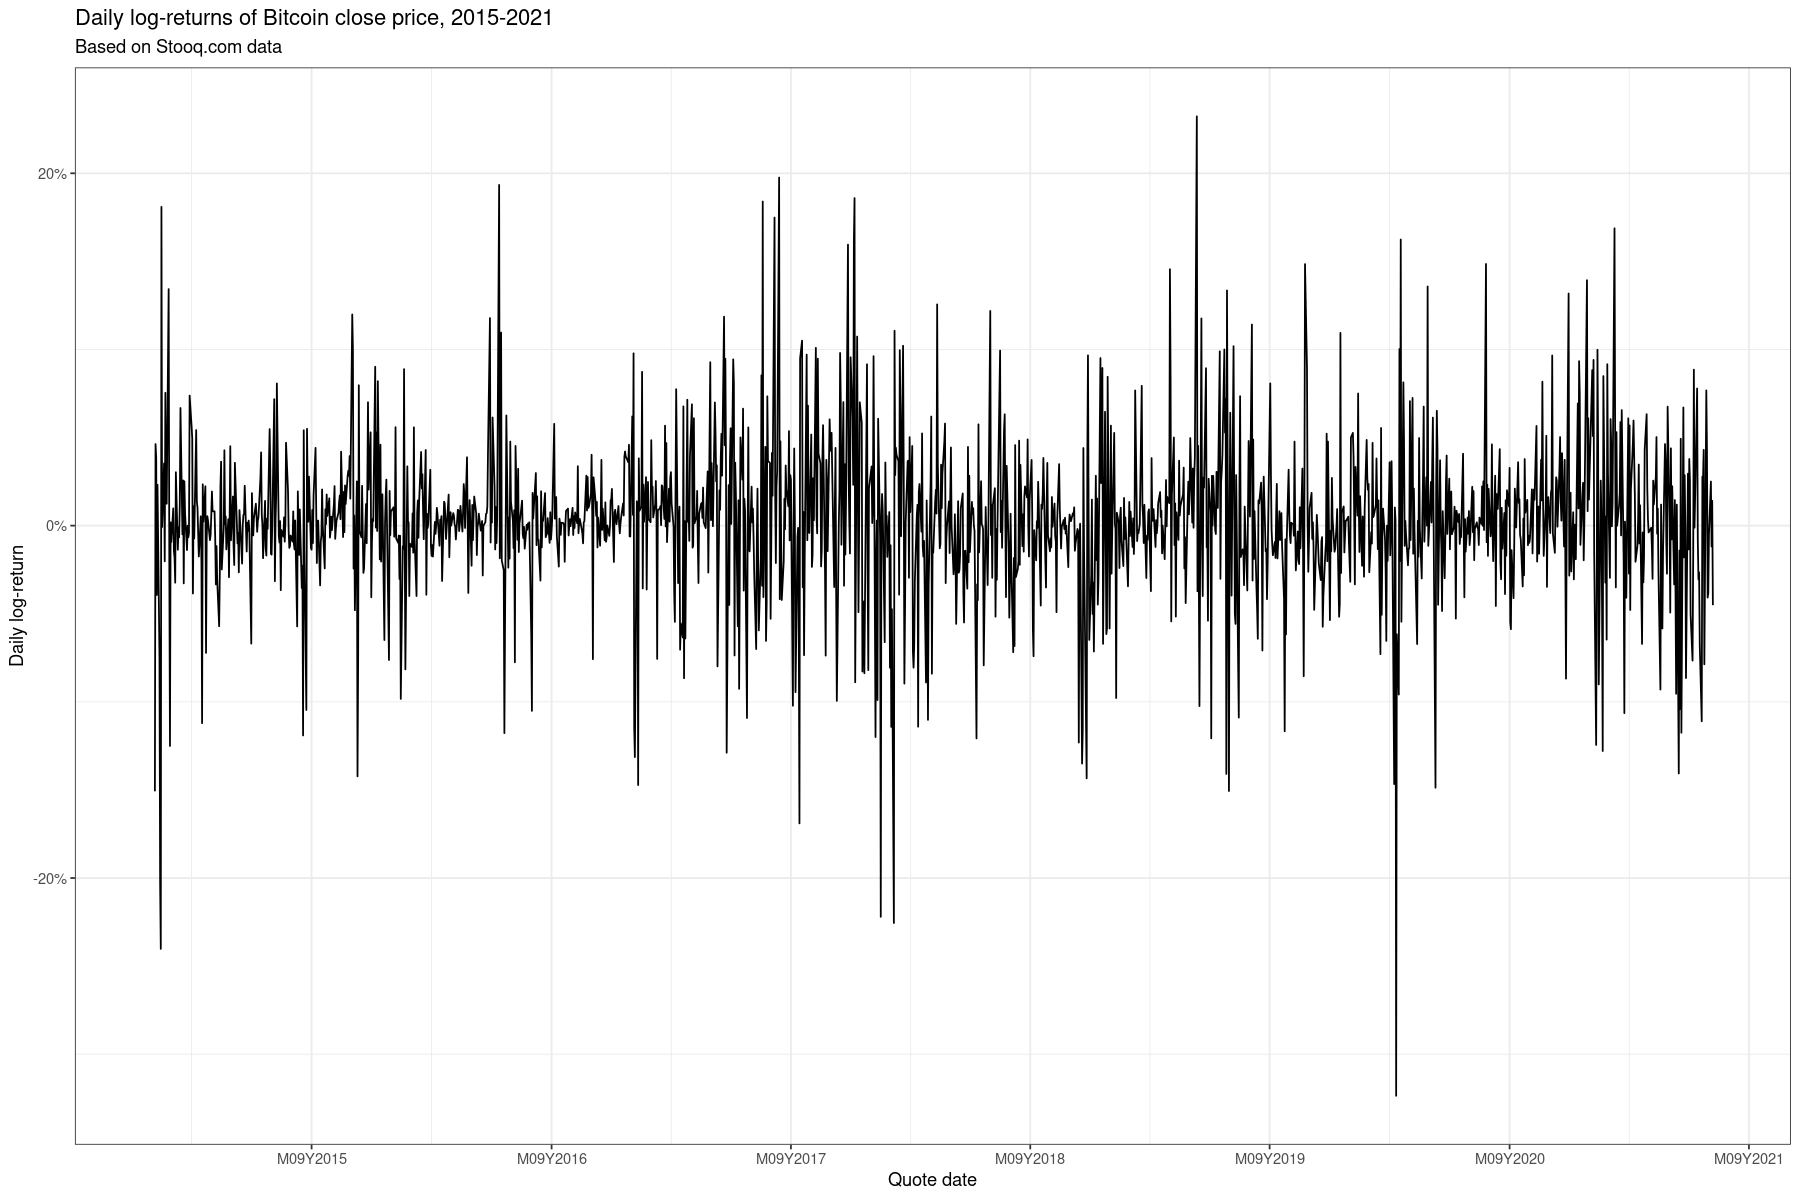

In [33]:
plotDailyLogReturns

In [34]:
plotDailySquaredLogreturns <- ggplot(data = dtBitcoinPrices, mapping = aes(x = quote_date, y = sq_logret_bitcoin_price)) +
  geom_line() + theme_bw() + 
  xlab("Quote date") + 
  ylab("Squared daily logreturn") +
  scale_x_date(
    date_labels = "M%mY%Y",
    date_breaks = "12 months"
  ) + 
  ggtitle(
    label = "Daily squared log-returns of Bitcoin close price, 2015-2021",
    subtitle = "Based on Stooq.com data"
  )

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


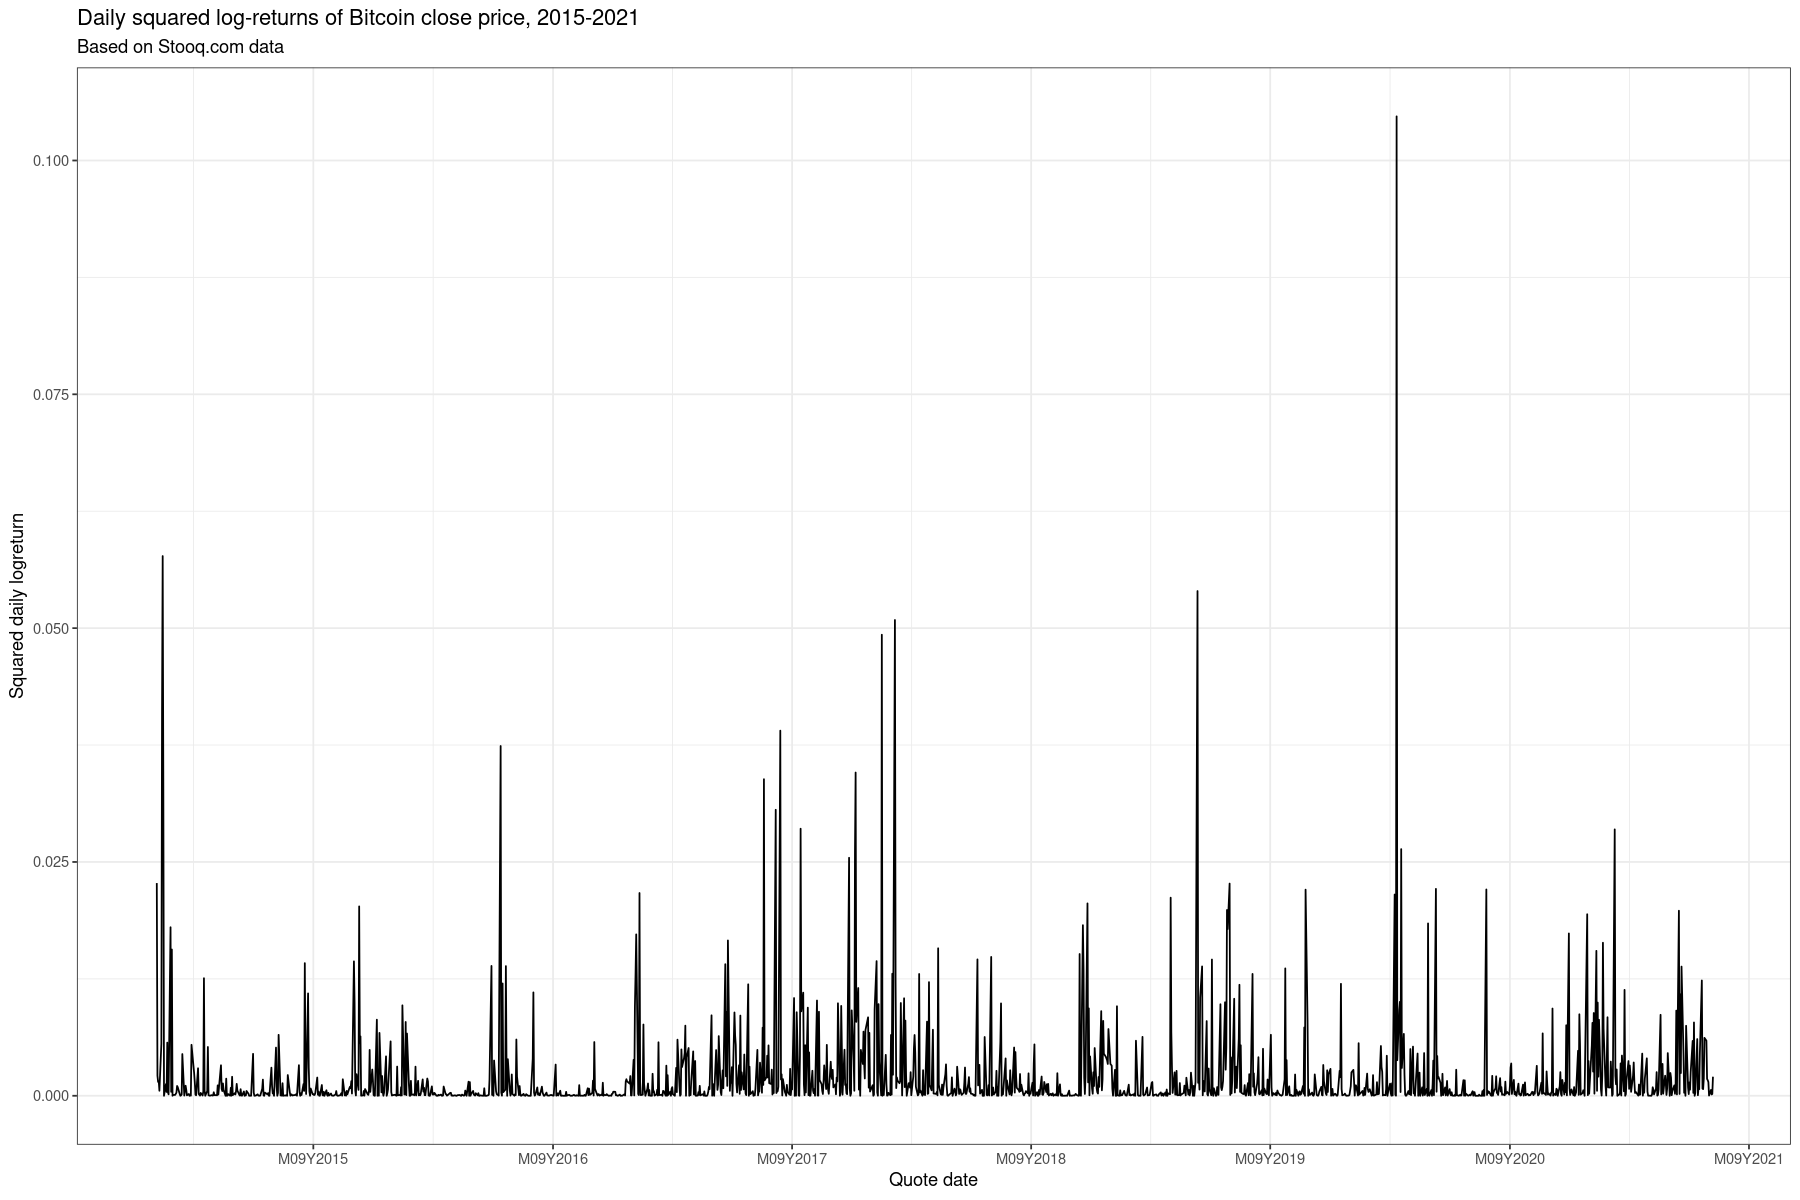

In [35]:
plotDailySquaredLogreturns